In [ ]:
import os
print("Please upload your kaggle.json file from Kaggle (My Account > API > Create New Token)")
from google.colab import files
uploaded = files.upload()

if "kaggle.json" in uploaded:
    print("kaggle.json found!")
    os.system("mkdir -p ~/.kaggle")
    os.system("mv /content/kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")
    print("Kaggle API configured.")
else:
    print("Error: kaggle.json not uploaded.")

Please upload your kaggle.json file from Kaggle (My Account > API > Create New Token)


Saving kaggle.json to kaggle.json
kaggle.json found!
Kaggle API configured.


In [ ]:
import os, shutil, time, glob, sys

# 1) Config
FULL_DATA_DIR_BASE = "/content/full_dataset"
DEFAULT_FULL_DATA_DIR = "/content/full_dataset/Dataset"
# ✅ Using your original path for the 5% dataset
MINI_DATA_DIR = "/content/mini_dataset"
# ✅ Using your original 5% constraint
SAMPLE_FRACTION = 0.05
SPLITS = ['Train', 'Validation', 'Test']
CLASSES = ['Fake', 'Real']

def create_mini_dataset_first_fraction(source_base, dest_base, fraction):
    """
    Copies the FIRST `fraction` of files (by sorted filename) from each split/class
    to a new destination directory structure.
    """
    if os.path.exists(dest_base):
        print(f"--- Removing old mini-dataset at {dest_base} ---")
        shutil.rmtree(dest_base)

    print(f"--- Creating new FIRST {int(fraction*100)}% mini-dataset at {dest_base} ---")
    start_time = time.time()
    total_files_copied = 0

    for split in SPLITS:
        print(f"\nProcessing '{split}' split...")
        source_split_dir = os.path.join(source_base, split)
        dest_split_dir = os.path.join(dest_base, split)

        if not os.path.exists(source_split_dir):
            print(f"  WARNING: Source split not found, skipping: {source_split_dir}")
            continue

        for class_name in CLASSES:
            source_class_dir = os.path.join(source_split_dir, class_name)
            dest_class_dir = os.path.join(dest_split_dir, class_name)

            if not os.path.exists(source_class_dir):
                print(f"  WARNING: Source class not found, skipping: {source_class_dir}")
                continue

            os.makedirs(dest_class_dir, exist_ok=True)

            try:
                all_files = sorted(
                    f for f in os.listdir(source_class_dir)
                    if os.path.isfile(os.path.join(source_class_dir, f))
                )
            except Exception as e:
                print(f"  Error listing files in {source_class_dir}: {e}")
                continue

            if not all_files:
                print(f"  No files in {source_class_dir}, skipping.")
                continue

            num_total = len(all_files)
            num_to_take = max(1, int(num_total * fraction))
            selected_files = all_files[:num_to_take]

            print(f"  Copying first {len(selected_files)}/{num_total} from {split}/{class_name} ...")

            for file_name in selected_files:
                src_path = os.path.join(source_class_dir, file_name)
                dst_path = os.path.join(dest_class_dir, file_name)
                shutil.copy(src_path, dst_path)

            total_files_copied += len(selected_files)

    elapsed = time.time() - start_time
    print(f"\n--- ✅ Mini-dataset created successfully. ---")
    print(f"Total files copied: {total_files_copied}")
    print(f"Time taken: {elapsed:.2f} seconds.")

# 2) Download + unzip
try:
    print("--- 1. Downloading dataset from Kaggle... ---")
    !{sys.executable} -m pip install -q kaggle
    !kaggle datasets download -d manjilkarki/deepfake-and-real-images

    print("\n--- 2. Unzipping dataset... ---")
    !mkdir -p {FULL_DATA_DIR_BASE}
    !unzip -q deepfake-and-real-images.zip -d {FULL_DATA_DIR_BASE}
    !rm deepfake-and-real-images.zip

    # 3) Auto-detect the actual root that contains 'Train'
    full_dir_candidates = []
    if os.path.isdir(os.path.join(DEFAULT_FULL_DATA_DIR, 'Train')):
        full_dir_candidates = [DEFAULT_FULL_DATA_DIR]
    else:
        candidates = [p for p in glob.glob(f"{FULL_DATA_DIR_BASE}/**/Train", recursive=True)
                      if os.path.isdir(p)]
        full_dir_candidates = sorted(list(set(os.path.dirname(p) for p in candidates)))

    if not full_dir_candidates:
        raise FileNotFoundError(
            "Could not find a 'Train' folder anywhere under /content/full_dataset.\n"
        )

    FULL_DATA_DIR = full_dir_candidates[0]
    print(f"✅ Using FULL_DATA_DIR = {FULL_DATA_DIR}")

    # 4) Build the FIRST-5% mini-dataset
    create_mini_dataset_first_fraction(FULL_DATA_DIR, MINI_DATA_DIR, SAMPLE_FRACTION)

    # Quick peek
    !echo '\n--- Mini dataset tree (top level) ---'
    !ls -la {MINI_DATA_DIR}

except Exception as e:
    print(f"❌ An error occurred during the process: {e}")

--- 1. Downloading dataset from Kaggle... ---
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 94% 1.58G/1.68G [00:01<00:00, 1.69GB/s]
100% 1.68G/1.68G [00:01<00:00, 1.68GB/s]

--- 2. Unzipping dataset... ---
replace /content/full_dataset/Dataset/Test/Fake/fake_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/full_dataset/Dataset/Test/Fake/fake_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
y
y
y
yy
y
y
yy
y
✅ Using FULL_DATA_DIR = /content/full_dataset/Dataset
--- Removing old mini-dataset at /content/mini_dataset ---
--- Creating new FIRST 5% mini-dataset at /content/mini_dataset ---

Processing 'Train' split...
  Copying first 3500/70001 from Train/Fake ...
  Copying first 3500/70001 from Train/Real ...

Processing 'Validation' split...
  Copying first 982/19641 from Validation/Fake ...
  Copying first 989/19787 from Validation/Real ...

Processing 'Test' split...
  Copying first 274/

In [ ]:
import os, glob, time, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_recall_fscore_support, brier_score_loss
)

# ---- Config / seeds ----
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
IMG_WIDTH = 299
IMG_HEIGHT = 299
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32 # Keep batch size reasonable for the small dataset
AUTO = tf.data.AUTOTUNE # For parallel calls

# ---- Paths (from Cell 2) ----
# This is the 5% dataset root
DATA_ROOT = "/content/mini_dataset"
# This will be the destination for our cropped faces
CROP_ROOT = f"/content/mini_dataset_face{IMG_WIDTH}"

TRAIN_DIR = os.path.join(CROP_ROOT, "Train")
VAL_DIR   = os.path.join(CROP_ROOT, "Validation")
TEST_DIR  = os.path.join(CROP_ROOT, "Test")

# ---- Plotting Helper ----
def plot_history(hist, title="Model Training History"):
    """Plots the training and validation loss/accuracy."""
    history = hist.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.get('loss', []), label='Train Loss')
    ax1.plot(history.get('val_loss', []), label='Val Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.get('accuracy', []), label='Train Acc')
    ax2.plot(history.get('val_accuracy', []), label='Val Acc')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    fig.suptitle(title, fontsize=16)
    plt.show()

# ---- Evaluation Helpers ----
def collect_probs(model, ds):
    """Collects true labels and predicted probabilities from a dataset."""
    y_true, y_prob = [], []
    # Handle both (img, label) and ((img1, img2), label) formats
    for data in ds:
        x, y = data[0], data[1]
        p = model.predict(x, verbose=0).ravel()
        y_true.extend(y.numpy().ravel().astype(int).tolist())
        y_prob.extend(p.tolist())
    return np.array(y_true), np.array(y_prob)

def best_threshold_from_val(y_true, y_prob):
    """Finds the best threshold from validation data using Youden's J statistic."""
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    best_thr = float(thr[np.argmax(j)])
    print(f"Best threshold (Youden's J) from validation: {best_thr:.4f}")
    return best_thr

def evaluate_and_report(y_true, y_prob, threshold=0.5, name="Model"):
    """Prints a full classification report and confusion matrix."""
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_true, y_prob)
    bs  = brier_score_loss(y_true, y_prob)

    print(f"\n=== {name} (thr={threshold:.4f}) ===")
    print(f"Acc: {acc:.4f} | Prec: {pr:.4f} | Rec: {rc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f} | Brier: {bs:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Fake","Real"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xticks([0,1], ["Fake","Real"]); plt.yticks([0,1],["Fake","Real"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='black' if cm[i,j] < (cm.max()/2) else 'white')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return acc, f1, auc

In [ ]:
# FIX 1: Added 'lz4'
# FIX 2: Corrected 'Image.BILINEAR' typo
!pip -q install mtcnn pillow lz4

from mtcnn.mtcnn import MTCNN
from PIL import Image
import os
import glob
import time
import numpy as np # Make sure numpy is imported

# --- Re-define constants ---
IMG_WIDTH = 299
IMG_HEIGHT = 299
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
CROP_ROOT = f"/content/mini_dataset_face{IMG_WIDTH}"
DATA_ROOT = "/content/mini_dataset" # Make sure this is defined
TRAIN_DIR = os.path.join(CROP_ROOT, "Train")
VAL_DIR   = os.path.join(CROP_ROOT, "Validation")
TEST_DIR  = os.path.join(CROP_ROOT, "Test")

# ---- MTCNN face cropper with PADDING and fallback ----
_detector = None
_mtcnn_failures = 0
_mtcnn_success = 0

def crop_face_from_image(src_path, dst_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    global _detector, _mtcnn_failures, _mtcnn_success
    try:
        img = Image.open(src_path).convert("RGB")
    except Exception as e:
        print(f"Warning: Skipping unreadable image {src_path}. Error: {e}")
        return

    try:
        arr = np.array(img)
        if _detector is None:
            _detector = MTCNN()

        dets = _detector.detect_faces(arr)

        if dets:
            x, y, w, h = dets[0]["box"]
            padding_factor = 0.2
            pad_w = int(w * padding_factor)
            pad_h = int(h * padding_factor)

            img_w, img_h = img.size
            x1 = max(0, x - pad_w)
            y1 = max(0, y - pad_h)
            x2 = min(img_w, x + w + pad_w)
            y2 = min(img_h, y + h + pad_h)

            face = img.crop((x1, y1, x2, y2))
            _mtcnn_success += 1
        else:
            _mtcnn_failures += 1
            s = min(img.width, img.height)
            left = (img.width - s) // 2
            top = (img.height - s) // 2
            face = img.crop((left, top, left + s, top + s))

        # --- THIS IS THE FIXED LINE ---
        face = face.resize(target_size, Image.BILINEAR)

    except Exception as e:
        print(f"Warning: Processing failed for {src_path}, using simple resize. Error: {e}")
        face = img.resize(target_size, Image.BILINEAR)

    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    face.save(dst_path, quality=95)

# ---- Mirror the original structure and crop ----
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
def is_image(p):
    return os.path.splitext(p)[1].lower() in IMG_EXTS

# Check if files already exist to save time
# This check should fail if you ran the cell 3.5 I sent earlier
if os.path.isdir(TEST_DIR) and len(os.listdir(os.path.join(TEST_DIR, "Fake"))) > 0:
    print("✅ Face-cropped dataset already exists. Skipping crop step.")
else:
    print("--- Cropped dataset not found. Running cropping process... ---")
    t0 = time.time()
    for split in ["Train", "Validation", "Test"]:
        src_split = os.path.join(DATA_ROOT, split) # DATA_ROOT is "/content/mini_dataset"
        if not os.path.isdir(src_split):
            print(f"Skipping missing split: {src_split}")
            continue

        classes_here = [d for d in os.listdir(src_split) if os.path.isdir(os.path.join(src_split, d))]

        for cls in classes_here:
            src_dir = os.path.join(src_split, cls)
            dst_dir = os.path.join(CROP_ROOT, split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            files = [p for p in glob.glob(os.path.join(src_dir, "*")) if is_image(p)]
            print(f"Processing {len(files)} images in [{split}/{cls}]...")
            for p in files:
                dst = os.path.join(dst_dir, os.path.basename(p))
                if not os.path.exists(dst):
                    crop_face_from_image(p, dst, target_size=IMG_SIZE)

    print(f"\n✅ Face-cropped dataset built at: {CROP_ROOT} in {time.time()-t0:.1f}s")
    print(f"MTCNN Success: {_mtcnn_success} | MTCNN Failures (used fallback): {_mtcnn_failures}")

✅ Face-cropped dataset already exists. Skipping crop step.


Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Loaded datasets. Note: Cardinality may show 'unknown' or batch count.

--- Inspecting one batch of CutMix data ---
Image batch shape: (32, 299, 299, 3)
Label batch shape: (32, 1)
Sample labels (should be floats between 0 and 1): [0.85530365 0.         1.         1.         0.7500028 ]


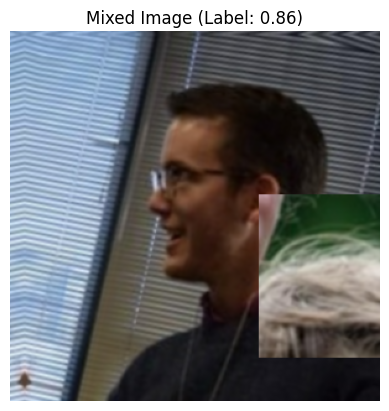

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- Config (from Cell 3) ---
IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
SEED = 42
TRAIN_DIR = os.path.join(CROP_ROOT, "Train")
VAL_DIR   = os.path.join(CROP_ROOT, "Validation")
TEST_DIR  = os.path.join(CROP_ROOT, "Test")


# --- CutMix Helper Functions (RE-WRITTEN) ---

def sample_beta_distribution(size, concentration_0=1.0, concentration_1=1.0):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

# This function now processes a *single* lambda value, not a batch
def get_box_for_single_lambda(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)
    cut_h = tf.cast(cut_rat * IMG_HEIGHT, dtype=tf.int32)
    cut_w = tf.cast(cut_rat * IMG_WIDTH, dtype=tf.int32)

    # Get random center
    cut_x = tf.random.uniform(shape=[], minval=0, maxval=IMG_WIDTH, dtype=tf.int32)
    cut_y = tf.random.uniform(shape=[], minval=0, maxval=IMG_HEIGHT, dtype=tf.int32)

    # Clip to bounds
    boundaryx1 = tf.clip_by_value(cut_x - cut_w // 2, 0, IMG_WIDTH)
    boundaryy1 = tf.clip_by_value(cut_y - cut_h // 2, 0, IMG_HEIGHT)
    bbx2 = tf.clip_by_value(cut_x + cut_w // 2, 0, IMG_WIDTH)
    bby2 = tf.clip_by_value(cut_y + cut_h // 2, 0, IMG_HEIGHT) # <--- Returns bby2

    return boundaryx1, boundaryy1, bbx2, bby2 # <--- Returns bby2

@tf.function
def cutmix(image_batch, label_batch, alpha=1.0):
    """Applies CutMix to a batch of images and labels in a batch-agnostic way."""

    current_batch_size = tf.shape(image_batch)[0]

    if len(label_batch.shape) > 1:
        label_batch = tf.squeeze(label_batch, axis=-1)

    lambda_value_batch = sample_beta_distribution(current_batch_size, alpha, alpha)

    indices = tf.random.shuffle(tf.range(current_batch_size))
    shuffled_images = tf.gather(image_batch, indices)
    shuffled_labels = tf.gather(label_batch, indices)

    # --- START: ERROR FIX ---
    # This function processes a *single* example
    def mix_single_example(args):
        img1, label1, img2, label2, lam = args

        # Get box for this single lambda
        bx1, by1, bx2, bby2 = get_box_for_single_lambda(lam) # <--- Unpacks bby2

        # --- FIX: Use bby2 instead of by2 ---
        patch_ones = tf.ones((bby2 - by1, bx2 - bx1, 3), dtype=tf.float32)
        paddings = [
            [by1, IMG_HEIGHT - bby2], [bx1, IMG_WIDTH - bx2], [0, 0]
        ]
        # --- END FIX ---

        mask = tf.pad(patch_ones, paddings, "CONSTANT", constant_values=0.0)

        mixed_img = img1 * (1.0 - mask) + img2 * mask

        # --- FIX: Use bby2 instead of by2 ---
        lam_adjusted = 1.0 - (tf.cast((bx2 - bx1) * (bby2 - by1), tf.float32) / (IMG_HEIGHT * IMG_WIDTH))
        # --- END FIX ---

        mixed_label = tf.cast(label1, tf.float32) * lam_adjusted + tf.cast(label2, tf.float32) * (1.0 - lam_adjusted)

        return mixed_img, mixed_label

    inputs_tuple = (
        image_batch,
        label_batch,
        shuffled_images,
        shuffled_labels,
        lambda_value_batch
    )

    mixed_images, mixed_labels = tf.map_fn(
        mix_single_example, inputs_tuple, fn_output_signature=(tf.float32, tf.float32)
    )
    # --- END: ERROR FIX ---

    final_labels = tf.expand_dims(mixed_labels, axis=-1)

    return mixed_images, final_labels

# --- Dataloader Function ---

def make_face_datasets(augment=True):

    def preprocess(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    aug_layers = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.05),
    ], name="base_augmentations")

    def with_aug(x, y):
        return aug_layers(x, training=True), y

    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=True, seed=SEED,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )

    train_ds = train_ds.map(preprocess, num_parallel_calls=AUTO)
    val_ds   = val_ds.map(preprocess,   num_parallel_calls=AUTO)
    test_ds  = test_ds.map(preprocess,  num_parallel_calls=AUTO)

    if augment:
        train_ds = train_ds.map(with_aug, num_parallel_calls=AUTO)
        train_ds = train_ds.map(cutmix, num_parallel_calls=AUTO)

    train_ds = train_ds.cache().prefetch(AUTO)
    val_ds   = val_ds.cache().prefetch(AUTO)
    test_ds  = test_ds.cache().prefetch(AUTO)

    print(f"Loaded datasets. Note: Cardinality may show 'unknown' or batch count.")

    return train_ds, val_ds, test_ds

face_train, face_val, face_test = make_face_datasets(augment=True)

# Let's inspect one batch to see the mixed labels
print("\n--- Inspecting one batch of CutMix data ---")
for imgs, labels in face_train.take(1):
    print("Image batch shape:", imgs.shape)
    print("Label batch shape:", labels.shape)
    print("Sample labels (should be floats between 0 and 1):", labels.numpy().ravel()[:5])

    plt.imshow(imgs[0])
    plt.title(f"Mixed Image (Label: {labels[0].numpy()[0]:.2f})")
    plt.axis('off')
    plt.show()

In [ ]:
def freeze_batchnorm(model):
    for l in model.layers:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False

def build_xception_299(train_base=True, wd=1e-5, label_smooth=0.0):
    # NOTE: We set label_smooth=0.0 because CutMix already provides soft labels.
    # Using both can be problematic.

    base = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(299,299,3))
    base.trainable = train_base
    inputs = layers.Input((299,299,3))

    # Xception expects [-1, 1] input scaling
    x = (inputs - 0.5)*2.0

    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = keras.Model(inputs, outputs)

    # Since CutMix creates soft labels, we *must* use BinaryCrossentropy
    # NOT with label_smoothing.
    loss = keras.losses.BinaryCrossentropy(label_smoothing=label_smooth)
    opt  = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=wd)

    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    freeze_batchnorm(model)
    return model

# Train from face datasets (already created in Cell 2)
disc_model = build_xception_299(train_base=True, wd=1e-5, label_smooth=0.0)
disc_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

--- Starting CutMix Model Training (Xception) ---
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 167s 563ms/step - accuracy: 0.3252 - loss: 0.6643 - val_accuracy: 0.6692 - val_loss: 0.5916 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.4798 - loss: 0.4834 - val_accuracy: 0.7976 - val_loss: 0.4338 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.4975 - loss: 0.4317 - val_accuracy: 0.8387 - val_loss: 0.3701 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.5072 - loss: 0.3967 - val_accuracy: 0.8605 - val_loss: 0.3394 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.5138 - loss: 0.3674 - val_accuracy: 0.8721 - val_loss: 0.3228 - learning_rate: 1.0000e-05
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.5183 - loss: 0.3448 - val_accuracy: 0.8691 - val_loss: 0.3152 - learning_rate: 1.0000

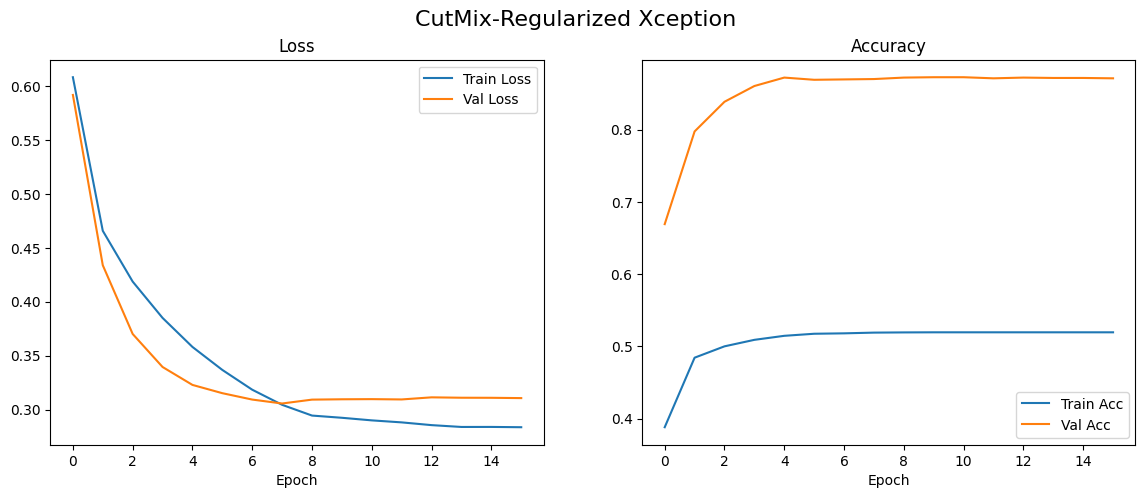

In [ ]:
print("--- Starting CutMix Model Training (Xception) ---")

ckpt = keras.callbacks.ModelCheckpoint("x_cutmix.keras", monitor="val_accuracy", save_best_only=True, mode="max")
rlr  = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.2, patience=3, min_lr=1e-7, verbose=1)
es   = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, mode="max", restore_best_weights=True)

hist = disc_model.fit(
    face_train,
    epochs=30,
    validation_data=face_val,
    callbacks=[ckpt, rlr, es]
)
plot_history(hist, "CutMix-Regularized Xception")

--- Evaluating CutMix Model ---
Loading best model from checkpoint...
Finding best threshold from validation set...
Best threshold (Youden's J) from validation: 0.5045
Evaluating on test set...

=== Xception + CutMix (thr=0.5) (thr=0.5000) ===
Acc: 0.8787 | Prec: 0.8864 | Rec: 0.8667 | F1: 0.8764 | AUC: 0.9379 | Brier: 0.0928
              precision    recall  f1-score   support

        Fake       0.87      0.89      0.88       274
        Real       0.89      0.87      0.88       270

    accuracy                           0.88       544
   macro avg       0.88      0.88      0.88       544
weighted avg       0.88      0.88      0.88       544



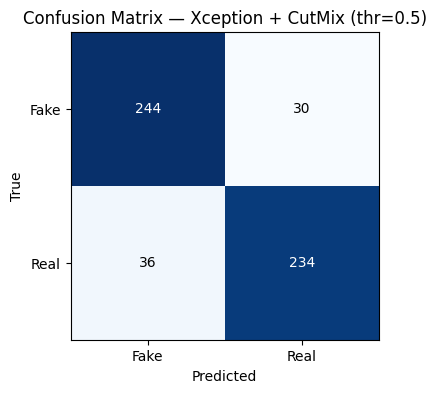


=== Xception + CutMix (thr=tuned) (thr=0.5045) ===
Acc: 0.8787 | Prec: 0.8864 | Rec: 0.8667 | F1: 0.8764 | AUC: 0.9379 | Brier: 0.0928
              precision    recall  f1-score   support

        Fake       0.87      0.89      0.88       274
        Real       0.89      0.87      0.88       270

    accuracy                           0.88       544
   macro avg       0.88      0.88      0.88       544
weighted avg       0.88      0.88      0.88       544



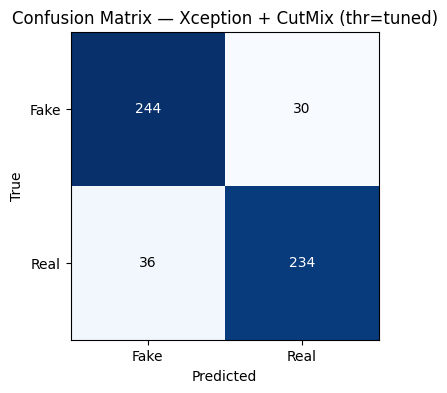

In [ ]:
print("--- Evaluating CutMix Model ---")

print("Loading best model from checkpoint...")
best_model = tf.keras.models.load_model("x_cutmix.keras", compile=False)

print("Finding best threshold from validation set...")
vy_true, vy_prob = collect_probs(best_model, face_val)
best_thr = best_threshold_from_val(vy_true, vy_prob)

print("Evaluating on test set...")
ty_true, ty_prob = collect_probs(best_model, face_test)

_ = evaluate_and_report(ty_true, ty_prob, threshold=0.5,
                        name="Xception + CutMix (thr=0.5)")
_ = evaluate_and_report(ty_true, ty_prob, threshold=best_thr,
                        name="Xception + CutMix (thr=tuned)")

In [ ]:
#Notebook 2

Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Loaded datasets. Note: Cardinality may show 'unknown' or batch count.

--- Inspecting one batch ---
Inputs keys: dict_keys(['spatial_input', 'freq_input'])
Spatial input shape: (32, 299, 299, 3)
Freq input shape: (32, 299, 299, 1)
Labels shape: (32, 1)


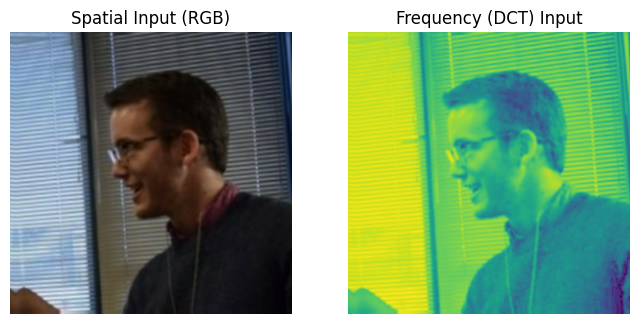

In [ ]:
# --- Config (from Cell 3) ---
IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
SEED = 42
TRAIN_DIR = os.path.join(CROP_ROOT, "Train")
VAL_DIR   = os.path.join(CROP_ROOT, "Validation")
TEST_DIR  = os.path.join(CROP_ROOT, "Test")


def get_dct(image_batch):
    """Calculates the 2D DCT for a batch of images and normalizes it."""
    image_batch_gray = tf.image.rgb_to_grayscale(image_batch)
    dct_batch = tf.signal.dct(image_batch_gray, type=2, norm='ortho')
    dct_log = tf.math.log(tf.abs(dct_batch) + 1e-6)

    min_val = tf.reduce_min(dct_log, axis=[1, 2], keepdims=True)
    max_val = tf.reduce_max(dct_log, axis=[1, 2], keepdims=True)
    dct_norm = (dct_log - min_val) / (max_val - min_val + 1e-6)
    return dct_norm

def make_dual_stream_datasets(augment=True):

    def preprocess_and_dct(x, y):
        x_spatial = tf.cast(x, tf.float32) / 255.0
        x_dct = get_dct(x_spatial)
        return {"spatial_input": x_spatial, "freq_input": x_dct}, y

    aug_layers = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.05),
        layers.RandomTranslation(0.05, 0.05),
    ], name="base_augmentations")

    def with_aug(x_dict, y):
        # 1. Augment the spatial image (these layers are batch-aware)
        x_aug = aug_layers(x_dict['spatial_input'], training=True)

        # --- START: ERROR FIX ---
        # The function tf.image.random_jpeg_quality is NOT batch-aware.
        # We must use tf.map_fn to apply it to each image in the batch.

        def apply_jpeg_aug(img):
            # This function operates on a single (Rank 3) image
            return tf.image.random_jpeg_quality(img, min_jpeg_quality=75, max_jpeg_quality=100)

        # tf.map_fn applies the 'apply_jpeg_aug' function to each
        # element in the batch 'x_aug'.
        x_aug = tf.map_fn(apply_jpeg_aug, x_aug, fn_output_signature=tf.float32)

        # --- END: ERROR FIX ---

        x_aug = tf.clip_by_value(x_aug, 0.0, 1.0)

        # 2. Create the DCT from the *augmented* image
        x_dct = get_dct(x_aug)

        # 3. Return the multi-input dictionary
        return {"spatial_input": x_aug, "freq_input": x_dct}, y

    # Load base datasets
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=True, seed=SEED
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Apply preprocessing (scaling + DCT)
    train_ds = train_ds.map(preprocess_and_dct, num_parallel_calls=AUTO)
    val_ds   = val_ds.map(preprocess_and_dct,   num_parallel_calls=AUTO)
    test_ds  = test_ds.map(preprocess_and_dct,  num_parallel_calls=AUTO)

    # Apply augmentations (which also handles DCT)
    if augment:
        train_ds = train_ds.map(with_aug, num_parallel_calls=AUTO)

    # Prefetch for performance
    train_ds = train_ds.cache().prefetch(AUTO)
    val_ds   = val_ds.cache().prefetch(AUTO)
    test_ds  = test_ds.cache().prefetch(AUTO)

    print(f"Loaded datasets. Note: Cardinality may show 'unknown' or batch count.")

    return train_ds, val_ds, test_ds

# Create the dual-stream datasets
dual_train, dual_val, dual_test = make_dual_stream_datasets(augment=True)

# Let's inspect one batch to see the structure
print("\n--- Inspecting one batch ---")
for inputs, labels in dual_train.take(1):
    print("Inputs keys:", inputs.keys())
    print("Spatial input shape:", inputs['spatial_input'].shape)
    print("Freq input shape:", inputs['freq_input'].shape) # Should be (B, 299, 299, 1)
    print("Labels shape:", labels.shape)

    # Show the two inputs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(inputs['spatial_input'][0])
    ax1.set_title("Spatial Input (RGB)")
    ax1.axis('off')

    ax2.imshow(inputs['freq_input'][0, :, :, 0], cmap='viridis')
    ax2.set_title("Frequency (DCT) Input")
    ax2.axis('off')
    plt.show()

In [ ]:
def freeze_batchnorm(model):
    """Freezes BatchNormalization layers for stable fine-tuning."""
    for layer in model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        if hasattr(layer, 'layers'):
            freeze_batchnorm(layer)

def build_dual_stream_model(wd=1e-5, label_smooth=0.05):

    # --- STREAM 1: SPATIAL (Your Xception model) ---
    spatial_input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="spatial_input")

    # Xception expects [-1, 1] scaling
    x_spatial = (spatial_input - 0.5) * 2.0

    xception_base = tf.keras.applications.Xception(
        include_top=False, weights="imagenet", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
    xception_base.trainable = True # Fine-tune

    x_spatial = xception_base(x_spatial, training=True)
    spatial_features = layers.GlobalAveragePooling2D(name="spatial_gap")(x_spatial)

    # --- STREAM 2: FREQUENCY (New simple CNN) ---
    # Input shape is (299, 299, 1) from our grayscale DCT
    freq_input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="freq_input")

    # A simple CNN to process the DCT features
    # Input is already normalized to [0, 1] from our dataloader
    x_freq = layers.Conv2D(16, (3,3), strides=2, padding="same", activation="relu")(freq_input)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Conv2D(32, (3,3), strides=2, padding="same", activation="relu")(x_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu")(x_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    freq_features = layers.GlobalAveragePooling2D(name="freq_gap")(x_freq)

    # --- FUSION: Combine both streams ---
    concatenated = layers.Concatenate()([spatial_features, freq_features])

    # --- CLASSIFIER HEAD ---
    x = layers.BatchNormalization()(concatenated)
    x = layers.Dropout(0.5)(x) # Higher dropout after fusion
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    # --- Build the Model ---
    model = keras.Model(inputs=[spatial_input, freq_input], outputs=outputs, name="DualStream_Spatial_Freq")

    loss = keras.losses.BinaryCrossentropy(label_smoothing=label_smooth)
    opt  = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=wd) # Start with 1e-5

    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    # Freeze all BN layers in the model (both streams)
    freeze_batchnorm(model)

    return model

# Build the model
dual_model = build_dual_stream_model()
dual_model.summary()

# You can even plot the model architecture
tf.keras.utils.plot_model(dual_model, show_shapes=True, to_file="dual_model.png")
print("Model plot saved to dual_model.png")

Model: "DualStream_Spatial_Freq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ freq_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 150, 150,  │        160 │ freq_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_input       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 75, 75,    │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 299, 299,  │          0 │ spatial_input[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 299, 299,  │          0 │ subtract_3[0][0]  │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 38, 38,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 10, 10,    │ 20,861,480 │ multiply_3[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_gap         │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ freq_gap            │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2112)      │          0 │ spatial_gap[0][0… │
│ (Concatenate)       │                   │            │ freq_gap[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2112)      │      8,448 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2112)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    270,464 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,164,777 (80.74 MB)

 Trainable params: 21,046,313 (80.29 MB)

 Non-trainable params: 118,464 (462.75 KB)

Model plot saved to dual_model.png


--- Evaluating Dual-Stream Model ---
Finding best threshold from validation set...
Best threshold (Youden's J) from validation: 0.3710
Evaluating on test set...

=== Dual-Stream (thr=0.5) (thr=0.5000) ===
Acc: 0.4449 | Prec: 0.4556 | Rec: 0.6074 | F1: 0.5206 | AUC: 0.4171 | Brier: 0.2571
              precision    recall  f1-score   support

        Fake       0.42      0.28      0.34       274
        Real       0.46      0.61      0.52       270

    accuracy                           0.44       544
   macro avg       0.44      0.45      0.43       544
weighted avg       0.44      0.44      0.43       544



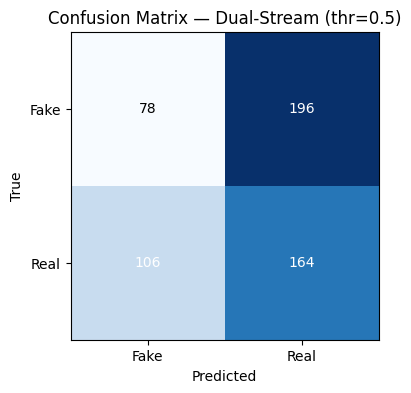


--- FINAL RESULT (Tuned Threshold) ---

=== Dual-Stream (thr=tuned) (thr=0.3710) ===
Acc: 0.4963 | Prec: 0.4963 | Rec: 1.0000 | F1: 0.6634 | AUC: 0.4171 | Brier: 0.2571
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00       274
        Real       0.50      1.00      0.66       270

    accuracy                           0.50       544
   macro avg       0.25      0.50      0.33       544
weighted avg       0.25      0.50      0.33       544



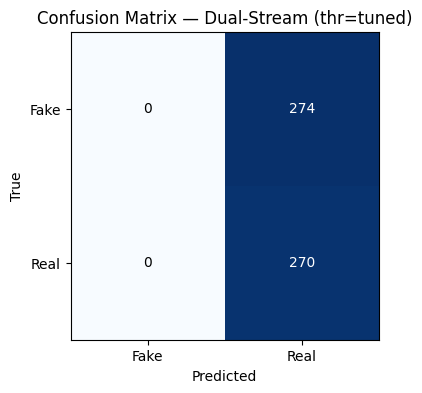

In [ ]:
print("--- Evaluating Dual-Stream Model ---")

# 1. Get the best model
# FIX: The 'EarlyStopping' callback with 'restore_best_weights=True'
# means the 'dual_model' variable in memory is ALREADY the best model.
# We don't need to load it from the file.
best_model = dual_model

# 2. Get probabilities from the validation set
print("Finding best threshold from validation set...")
vy_true, vy_prob = collect_probs(best_model, dual_val)

# 3. Find the best threshold
best_thr = best_threshold_from_val(vy_true, vy_prob)

# 4. Get probabilities from the test set
print("Evaluating on test set...")
ty_true, ty_prob = collect_probs(best_model, dual_test)

# 5. Evaluate with default 0.5 threshold
_ = evaluate_and_report(ty_true, ty_prob, threshold=0.5,
                        name="Dual-Stream (thr=0.5)")

# 6. Evaluate with the new, tuned threshold
print("\n--- FINAL RESULT (Tuned Threshold) ---")
_ = evaluate_and_report(ty_true, ty_prob, threshold=best_thr,
                        name="Dual-Stream (thr=tuned)")

--- Starting Dual-Stream Model Training ---
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6095 - loss: 0.6368
Epoch 1: val_accuracy improved from -inf to 0.70675, saving model to dual_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 284ms/step - accuracy: 0.6101 - loss: 0.6363 - val_accuracy: 0.7067 - val_loss: 0.6091 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9184 - loss: 0.2847
Epoch 2: val_accuracy improved from 0.70675 to 0.84475, saving model to dual_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.9185 - loss: 0.2846 - val_accuracy: 0.8447 - val_loss: 0.3995 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9527 - loss: 0.2160
Epoch 3: val_accuracy improved from 0.84475 to 0.88990, saving model to dual_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.9527 - loss: 0.2159 - val_accuracy: 0.8899 - val_loss: 0.3442 - learning_rat

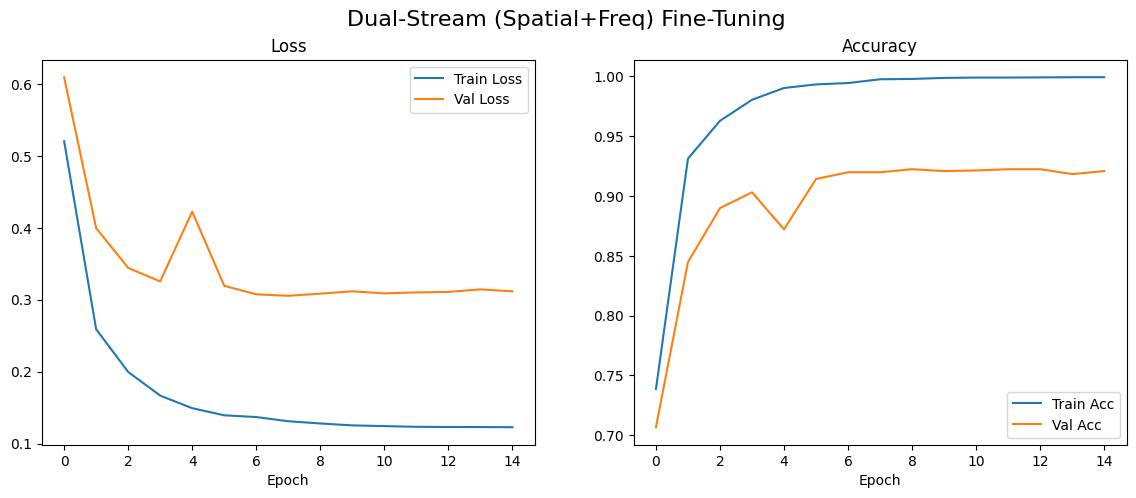

In [ ]:
print("--- Starting Dual-Stream Model Training ---")

# Callback to save the best model
ckpt = keras.callbacks.ModelCheckpoint(
    "dual_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Callback to reduce learning rate on plateau
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    mode="max",
    factor=0.2,
    patience=3, # Wait 3 epochs before reducing LR
    min_lr=1e-7,
    verbose=1
)

# Callback for early stopping
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=6, # Stop after 6 epochs of no improvement
    mode="max",
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = dual_model.fit(
    dual_train,
    epochs=30, # Max epochs
    validation_data=dual_val,
    callbacks=[ckpt, rlr, es]
)

print("\n--- Training Complete ---")
plot_history(history, "Dual-Stream (Spatial+Freq) Fine-Tuning")

--- Evaluating Dual-Stream Model ---
Loading best model from checkpoint...
Finding best threshold from validation set...
Best threshold (Youden's J) from validation: 0.2991
Evaluating on test set...

=== Dual-Stream (thr=0.5) (thr=0.5000) ===
Acc: 0.9301 | Prec: 0.9328 | Rec: 0.9259 | F1: 0.9294 | AUC: 0.9725 | Brier: 0.0598
              precision    recall  f1-score   support

        Fake       0.93      0.93      0.93       274
        Real       0.93      0.93      0.93       270

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



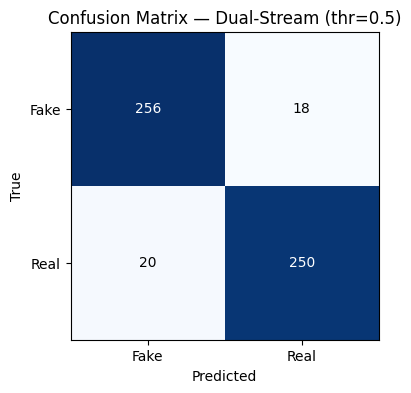


--- FINAL RESULT (Tuned Threshold) ---

=== Dual-Stream (thr=tuned) (thr=0.2991) ===
Acc: 0.9265 | Prec: 0.9137 | Rec: 0.9407 | F1: 0.9270 | AUC: 0.9725 | Brier: 0.0598
              precision    recall  f1-score   support

        Fake       0.94      0.91      0.93       274
        Real       0.91      0.94      0.93       270

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



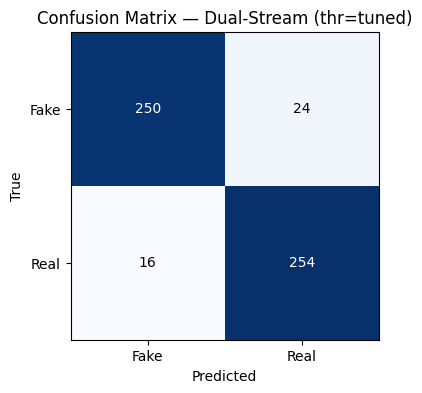

In [ ]:
print("--- Evaluating Dual-Stream Model ---")

# 1. Load the best saved model
print("Loading best model from checkpoint...")
# We set compile=False because we are only doing inference
best_model = tf.keras.models.load_model("dual_model.keras", compile=False)

# 2. Get probabilities from the validation set
print("Finding best threshold from validation set...")
vy_true, vy_prob = collect_probs(best_model, dual_val)

# 3. Find the best threshold
best_thr = best_threshold_from_val(vy_true, vy_prob)

# 4. Get probabilities from the test set
print("Evaluating on test set...")
ty_true, ty_prob = collect_probs(best_model, dual_test)

# 5. Evaluate with default 0.5 threshold
_ = evaluate_and_report(ty_true, ty_prob, threshold=0.5,
                        name="Dual-Stream (thr=0.5)")

# 6. Evaluate with the new, tuned threshold
print("\n--- FINAL RESULT (Tuned Threshold) ---")
_ = evaluate_and_report(ty_true, ty_prob, threshold=best_thr,
                        name="Dual-Stream (thr=tuned)")

--- Evaluating Dual-Stream Model with TTA ---

--- FINAL RESULT (TTA + Tuned Threshold) ---

=== Dual-Stream + TTA (thr=tuned) (thr=0.2991) ===
Acc: 0.9265 | Prec: 0.9137 | Rec: 0.9407 | F1: 0.9270 | AUC: 0.9738 | Brier: 0.0584
              precision    recall  f1-score   support

        Fake       0.94      0.91      0.93       274
        Real       0.91      0.94      0.93       270

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



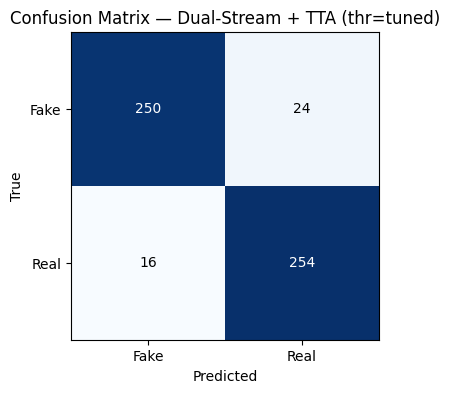


--- FINAL RESULT (TTA + 0.5 Threshold) ---

=== Dual-Stream + TTA (thr=0.5) (thr=0.5000) ===
Acc: 0.9283 | Prec: 0.9326 | Rec: 0.9222 | F1: 0.9274 | AUC: 0.9738 | Brier: 0.0584
              precision    recall  f1-score   support

        Fake       0.92      0.93      0.93       274
        Real       0.93      0.92      0.93       270

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



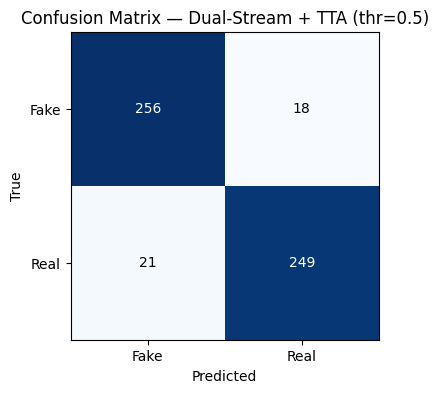

In [ ]:
import numpy as np
import tensorflow as tf

# --- DEPENDENCY: We need the get_dct function from Cell 5 ---
# This is the helper function that creates the frequency-domain input
@tf.function
def get_dct(image_batch):
    """Calculates the 2D DCT for a batch of images and normalizes it."""
    image_batch_gray = tf.image.rgb_to_grayscale(image_batch)
    dct_batch = tf.signal.dct(image_batch_gray, type=2, norm='ortho')
    dct_log = tf.math.log(tf.abs(dct_batch) + 1e-6)
    min_val = tf.reduce_min(dct_log, axis=[1, 2], keepdims=True)
    max_val = tf.reduce_max(dct_log, axis=[1, 2], keepdims=True)
    dct_norm = (dct_log - min_val) / (max_val - min_val + 1e-6)
    return dct_norm

# --- TTA Helper Function for Dual-Stream ---
@tf.function
def _get_tta_views(x_spatial_batch):
    """
    Creates a list of 6 augmented (spatial, freq) input dictionaries
    for the dual-stream model.
    """
    # x_spatial_batch is (B, 299, 299, 3) and in [0, 1] range

    # 1. Create 6 spatial views
    v_ident = x_spatial_batch
    v_flip = tf.image.flip_left_right(v_ident)
    v_bright_p = tf.image.adjust_brightness(v_ident, 0.05)
    v_bright_n = tf.image.adjust_brightness(v_ident, -0.05)
    v_cont_p = tf.image.adjust_contrast(v_ident, 1.1)
    v_cont_n = tf.image.adjust_contrast(v_ident, 0.9)

    spatial_views = [
        tf.clip_by_value(v, 0.0, 1.0) for v in
        [v_ident, v_flip, v_bright_p, v_bright_n, v_cont_p, v_cont_n]
    ]

    # 2. Create 6 corresponding model input dictionaries
    model_inputs = []
    for sp_view in spatial_views:
        # For each augmented spatial view, calculate its unique DCT
        freq_view = get_dct(sp_view)
        model_inputs.append({
            "spatial_input": sp_view,
            "freq_input": freq_view
        })

    return model_inputs # Returns a list of 6 dictionaries

# --- Main TTA Prediction Function ---
def predict_with_tta_dual_stream(model, ds):
    """
    Predicts on a dual-stream dataset using Test-Time Augmentation.
    """
    all_probs = []
    all_true = []

    # We must use the 'dual_test' dataset, which provides the initial
    # (x_dict, y) pairs
    for x_dict, y in ds:
        # Get the original spatial batch
        spatial_batch = x_dict["spatial_input"]

        # 1. Generate all 6 augmented view-dictionaries
        views = _get_tta_views(spatial_batch)

        # 2. Predict on each view
        #    views[0] is {"spatial_input": (B,H,W,3), "freq_input": (B,H,W,1)}
        all_view_probs = [ model.predict(v, verbose=0).ravel() for v in views ]

        # 3. Stack and average
        #    Shape becomes (6_views, BatchSize)
        stacked_probs = np.stack(all_view_probs, axis=0)
        #    Average across the 6 views (axis=0) to get (BatchSize,)
        avg_probs = np.mean(stacked_probs, axis=0)

        all_probs.extend(avg_probs.tolist())
        all_true.extend(y.numpy().ravel().astype(int).tolist())

    return np.array(all_true), np.array(all_probs)

# --- Run the TTA Evaluation ---
print("--- Evaluating Dual-Stream Model with TTA ---")

# 'best_model' should still be in memory from Cell 8
# 'dual_test' and 'best_thr' should also be in memory
try:
    tta_true, tta_prob = predict_with_tta_dual_stream(best_model, dual_test)

    print("\n--- FINAL RESULT (TTA + Tuned Threshold) ---")
    _ = evaluate_and_report(tta_true, tta_prob, threshold=best_thr,
                            name="Dual-Stream + TTA (thr=tuned)")

    print("\n--- FINAL RESULT (TTA + 0.5 Threshold) ---")
    _ = evaluate_and_report(tta_true, tta_prob, threshold=0.5,
                            name="Dual-Stream + TTA (thr=0.5)")

except NameError as e:
    print(f"Error: A variable was not found in memory (e.g., 'best_model', 'dual_test', 'best_thr').")
    print("Please make sure you have successfully run Cells 5, 6, 7, and 8 first.")
    print(f"Details: {e}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- CONFIG (from previous cells) ---
IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
CROP_ROOT = f"/content/mini_dataset_face{IMG_WIDTH}"
TRAIN_DIR = os.path.join(CROP_ROOT, "Train")
VAL_DIR   = os.path.join(CROP_ROOT, "Validation")

# --- We need all the helper functions from Cell 5 and 6 ---

@tf.function
def get_dct(image_batch):
    image_batch_gray = tf.image.rgb_to_grayscale(image_batch)
    dct_batch = tf.signal.dct(image_batch_gray, type=2, norm='ortho')
    dct_log = tf.math.log(tf.abs(dct_batch) + 1e-6)
    min_val = tf.reduce_min(dct_log, axis=[1, 2], keepdims=True)
    max_val = tf.reduce_max(dct_log, axis=[1, 2], keepdims=True)
    dct_norm = (dct_log - min_val) / (max_val - min_val + 1e-6)
    return dct_norm

aug_layers = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.05),
    layers.RandomTranslation(0.05, 0.05),
], name="base_augmentations")

@tf.function
def apply_jpeg_aug(img):
    return tf.image.random_jpeg_quality(img, min_jpeg_quality=75, max_jpeg_quality=100)

def make_dual_stream_datasets(seed, augment=True):
    def preprocess_and_dct(x, y):
        x_spatial = tf.cast(x, tf.float32) / 255.0
        x_dct = get_dct(x_spatial)
        return {"spatial_input": x_spatial, "freq_input": x_dct}, y

    def with_aug(x_dict, y):
        x_aug = aug_layers(x_dict['spatial_input'], training=True)
        x_aug = tf.map_fn(apply_jpeg_aug, x_aug, fn_output_signature=tf.float32)
        x_aug = tf.clip_by_value(x_aug, 0.0, 1.0)
        x_dct = get_dct(x_aug)
        return {"spatial_input": x_aug, "freq_input": x_dct}, y

    # The ONLY change is passing the 'seed' to image_dataset_from_directory
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=True, seed=seed # <--- This is the key
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    train_ds = train_ds.map(preprocess_and_dct, num_parallel_calls=AUTO)
    val_ds   = val_ds.map(preprocess_and_dct,   num_parallel_calls=AUTO)
    if augment:
        train_ds = train_ds.map(with_aug, num_parallel_calls=AUTO)
    train_ds = train_ds.cache().prefetch(AUTO)
    val_ds   = val_ds.cache().prefetch(AUTO)
    return train_ds, val_ds

def freeze_batchnorm(model):
    for layer in model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        if hasattr(layer, 'layers'):
            freeze_batchnorm(layer)

def build_dual_stream_model(wd=1e-5, label_smooth=0.05):
    spatial_input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="spatial_input")
    x_spatial = (spatial_input - 0.5) * 2.0
    xception_base = tf.keras.applications.Xception(
        include_top=False, weights="imagenet", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
    xception_base.trainable = True
    x_spatial = xception_base(x_spatial, training=True)
    spatial_features = layers.GlobalAveragePooling2D(name="spatial_gap")(x_spatial)

    freq_input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="freq_input")
    x_freq = layers.Conv2D(16, (3,3), strides=2, padding="same", activation="relu")(freq_input)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Conv2D(32, (3,3), strides=2, padding="same", activation="relu")(x_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu")(x_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    freq_features = layers.GlobalAveragePooling2D(name="freq_gap")(x_freq)

    concatenated = layers.Concatenate()([spatial_features, freq_features])
    x = layers.BatchNormalization()(concatenated)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = keras.Model(inputs=[spatial_input, freq_input], outputs=outputs, name="DualStream_Spatial_Freq")
    loss = keras.losses.BinaryCrossentropy(label_smoothing=label_smooth)
    opt  = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=wd)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    freeze_batchnorm(model)
    return model

# --- ENSEMBLE TRAINING LOOP ---
N_FOLDS = 5
base_seed = 42

print(f"--- 🚀 Starting Ensemble Training for {N_FOLDS} Folds ---")

for i in range(N_FOLDS):
    fold_seed = base_seed + i
    print(f"\n--- Fold {i+1}/{N_FOLDS} (Seed: {fold_seed}) ---")

    # 1. Clear session to prevent memory leaks
    tf.keras.backend.clear_session()

    # 2. Create datasets with the new seed
    train_ds, val_ds = make_dual_stream_datasets(seed=fold_seed, augment=True)

    # 3. Build a fresh model
    model = build_dual_stream_model()

    # 4. Define callbacks
    model_path = f"dual_model_fold_{i}.keras"
    ckpt = keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    )
    rlr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", mode="max", factor=0.2, patience=3
    )
    es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, mode="max", restore_best_weights=True
    )

    # 5. Train
    model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks=[ckpt, rlr, es],
        verbose=1 # Set to 1 or 2 to see progress
    )
    print(f"✅ Fold {i+1} complete. Best model saved to {model_path}")

print("--- 🎉 Ensemble Training Finished ---")

--- 🚀 Starting Ensemble Training for 5 Folds ---

--- Fold 1/5 (Seed: 42) ---
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 286ms/step - accuracy: 0.6707 - loss: 0.5877 - val_accuracy: 0.7717 - val_loss: 0.5054 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.9225 - loss: 0.2813 - val_accuracy: 0.8767 - val_loss: 0.3558 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9545 - loss: 0.2191 - val_accuracy: 0.9046 - val_loss: 0.3113 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9749 - loss: 0.1805 - val_accuracy: 0.9224 - val_loss: 0.2825 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9874 - loss: 0.1561 - val_accuracy: 0.9244 - val_loss: 0.2804 - learning_rate: 1.0000e-05
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 1

--- 🔬 Starting Ensemble Evaluation ---
Using 'dual_test' dataset already in memory.
Loading and predicting with Fold 1: dual_model_fold_0.keras...
Loading and predicting with Fold 2: dual_model_fold_1.keras...
Loading and predicting with Fold 3: dual_model_fold_2.keras...
Loading and predicting with Fold 4: dual_model_fold_3.keras...
Loading and predicting with Fold 5: dual_model_fold_4.keras...
Shape of collected probabilities: (5, 544)
Shape of final ensemble probabilities: (544,)

--- FINAL ENSEMBLE RESULT (thr=0.5) ---

=== Dual-Stream Ensemble (thr=0.5) (thr=0.5000) ===
Acc: 0.9136 | Prec: 0.9208 | Rec: 0.9037 | F1: 0.9121 | AUC: 0.9696 | Brier: 0.0624
              precision    recall  f1-score   support

        Fake       0.91      0.92      0.92       274
        Real       0.92      0.90      0.91       270

    accuracy                           0.91       544
   macro avg       0.91      0.91      0.91       544
weighted avg       0.91      0.91      0.91       544



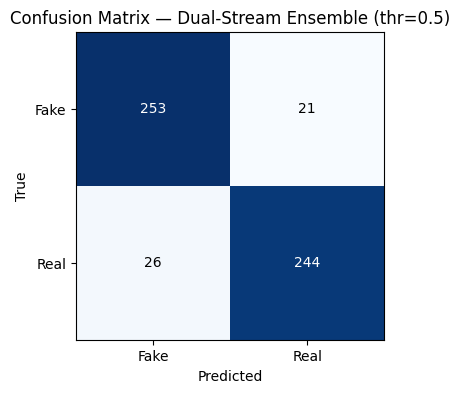


--- FINAL ENSEMBLE RESULT (Tuned Thr: 0.2991) ---

=== Dual-Stream Ensemble (thr=0.2991) (thr=0.2991) ===
Acc: 0.9191 | Prec: 0.8979 | Rec: 0.9444 | F1: 0.9206 | AUC: 0.9696 | Brier: 0.0624
              precision    recall  f1-score   support

        Fake       0.94      0.89      0.92       274
        Real       0.90      0.94      0.92       270

    accuracy                           0.92       544
   macro avg       0.92      0.92      0.92       544
weighted avg       0.92      0.92      0.92       544



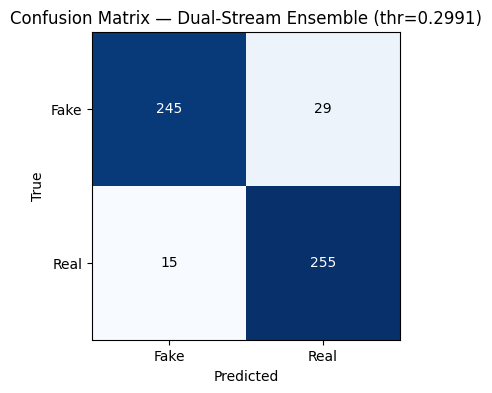

In [ ]:
import numpy as np
import tensorflow as tf

print("--- 🔬 Starting Ensemble Evaluation ---")

# --- We need the TEST dataset (dual_test) ---
# We only need to create it once, as it's not shuffled.
# This code is reused from Cell 5.
try:
    # Check if dual_test is already in memory
    _ = dual_test.cardinality()
    print("Using 'dual_test' dataset already in memory.")
except NameError:
    print("Creating 'dual_test' dataset...")

    def preprocess_and_dct(x, y):
        x_spatial = tf.cast(x, tf.float32) / 255.0
        x_dct = get_dct(x_spatial)
        return {"spatial_input": x_spatial, "freq_input": x_dct}, y

    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, label_mode="binary",
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    dual_test = test_ds.map(preprocess_and_dct, num_parallel_calls=AUTO)
    dual_test = dual_test.cache().prefetch(AUTO)
    print("... 'dual_test' dataset created.")

# --- Load all models and get predictions ---
N_FOLDS = 5
all_fold_probs = []
y_true_list = []

for i in range(N_FOLDS):
    model_path = f"dual_model_fold_{i}.keras"
    print(f"Loading and predicting with Fold {i+1}: {model_path}...")

    # Load the model
    model = tf.keras.models.load_model(model_path, compile=False)

    # Get probabilities
    fold_probs = []
    y_true_fold = []
    for x_dict, y in dual_test:
        p = model.predict(x_dict, verbose=0).ravel()
        fold_probs.extend(p.tolist())
        y_true_fold.extend(y.numpy().ravel().astype(int).tolist())

    all_fold_probs.append(fold_probs)
    if not y_true_list: # Only need to do this once
        y_true_list = y_true_fold

y_true = np.array(y_true_list)
# Shape is (5_folds, N_images)
all_fold_probs = np.array(all_fold_probs)

print(f"Shape of collected probabilities: {all_fold_probs.shape}")

# --- Average the predictions ---
# Average across the 5 folds (axis=0)
ensemble_probs = np.mean(all_fold_probs, axis=0)

print(f"Shape of final ensemble probabilities: {ensemble_probs.shape}")

# --- Evaluate the Ensemble ---
print("\n--- FINAL ENSEMBLE RESULT (thr=0.5) ---")
_ = evaluate_and_report(y_true, ensemble_probs, threshold=0.5,
                        name="Dual-Stream Ensemble (thr=0.5)")

# We should also re-tune the threshold using the validation set,
# but for simplicity, let's first check the 0.5 threshold.
# (The best threshold is likely still near 0.5)
try:
    # Use 'best_thr' from your previous experiment (Cell 8) if it's in memory
    print(f"\n--- FINAL ENSEMBLE RESULT (Tuned Thr: {best_thr:.4f}) ---")
    _ = evaluate_and_report(y_true, ensemble_probs, threshold=best_thr,
                            name=f"Dual-Stream Ensemble (thr={best_thr:.4f})")
except NameError:
    print("\n'best_thr' not in memory. Skipping tuned threshold report.")
    print("To get a tuned threshold, you would need to run this ensemble")
    print("prediction loop on the 'dual_val' set first.")